# Duckdb python API

- the same way of leading sakila data sa via terminal


In [1]:
import duckdb
from pathlib import Path

In [2]:
# duckdb path
duckdb_path = "data/sakila.duckdb"
Path(duckdb_path).unlink(missing_ok=True)
# Connect to duckdb file with context manager
# with statement
# the same way to ingest it in duckdb terminal duckdb..... < sql/ingest..
with duckdb.connect(duckdb_path) as conn, open("sql/load_sakila.sql") as ingest_scripts:
    # connect script and read the content
    conn.sql(ingest_scripts.read())
    # create pandas dataframe from the created duckdb connection
    description = conn.sql("DESC;").df()
    film = conn.sql("FROM film;").df()


# check put the created dataframes
film.head()

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,<NA>,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2021-03-06 15:52:00
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,<NA>,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2021-03-06 15:52:00
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,<NA>,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",2021-03-06 15:52:00
3,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,2006,1,<NA>,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",2021-03-06 15:52:00
4,5,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,<NA>,6,2.99,130,22.99,G,Deleted Scenes,2021-03-06 15:52:00


In [3]:
description.head(3)

,database,schema,name,column_names,column_types,temporary
0,sakila,main,actor,"[actor_id, first_name, last_name, last_update]","[DOUBLE, VARCHAR, VARCHAR, TIMESTAMP]",False
1,sakila,main,address,"[address_id, address, address2, district, city...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, VA...",False
2,sakila,main,category,"[category_id, name, last_update]","[BIGINT, VARCHAR, TIMESTAMP]",False


## read all the tables into dataframes


In [4]:
# creating dataframes under 1 dictionary
# create a dictonary to keep all dataframes
dfs = {}

with duckdb.connect(duckdb_path) as conn:
    # look for the name - columns in the database
    for name in description["name"]:
        # put the name into a key in the dictionary
        dfs[name] = conn.sql(f"FROM {name};").df()

In [5]:
# check the resulting dictionary

# check how many keys and names of them
dfs.keys()

dict_keys(['actor', 'address', 'category', 'city', 'country', 'customer', 'customer_list', 'film', 'film_actor', 'film_category', 'film_list', 'film_text', 'inventory', 'language', 'payment', 'rental', 'sales_by_film_category', 'sales_by_store', 'staff', 'staff_list', 'store'])

In [6]:
dfs["actor"]

,actor_id,first_name,last_name,last_update
0,1.0,PENELOPE,GUINESS,2021-03-06 15:51:59
1,2.0,NICK,WAHLBERG,2021-03-06 15:51:59
2,3.0,ED,CHASE,2021-03-06 15:51:59
3,4.0,JENNIFER,DAVIS,2021-03-06 15:51:59
4,5.0,JOHNNY,LOLLOBRIGIDA,2021-03-06 15:51:59
...,...,...,...,...
195,196.0,BELA,WALKEN,2021-03-06 15:52:00
196,197.0,REESE,WEST,2021-03-06 15:52:00
197,198.0,MARY,KEITEL,2021-03-06 15:52:00
198,199.0,JULIA,FAWCETT,2021-03-06 15:52:00


In [7]:
# each value fot each key in the dictionary is a pd df

type(dfs["actor"])

pandas.core.frame.DataFrame

In [8]:
dfs["actor"].head(3)

,actor_id,first_name,last_name,last_update
0,1.0,PENELOPE,GUINESS,2021-03-06 15:51:59
1,2.0,NICK,WAHLBERG,2021-03-06 15:51:59
2,3.0,ED,CHASE,2021-03-06 15:51:59


## Register dfs to duckdb

- join dataframes


In [9]:
# 1 paramter - name of the table (string)
# 2 parameter- source of the table
duckdb.register("actor", dfs["actor"])

In [10]:
# Same thing but with a loop so you don't have to repeat code
table_names = ["film", "film_actor", "film_category", "actor", "category"]

for table_name in table_names:
    duckdb.register(table_name, dfs[table_name])

# show the result of the registration
duckdb.sql("DESC;").df()

,database,schema,name,column_names,column_types,temporary
0,temp,main,actor,"[actor_id, first_name, last_name, last_update]","[DOUBLE, VARCHAR, VARCHAR, TIMESTAMP]",True
1,temp,main,category,"[category_id, name, last_update]","[BIGINT, VARCHAR, TIMESTAMP]",True
2,temp,main,film,"[film_id, title, description, release_year, la...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, BI...",True
3,temp,main,film_actor,"[actor_id, film_id, last_update]","[BIGINT, BIGINT, TIMESTAMP]",True
4,temp,main,film_category,"[film_id, category_id, last_update]","[BIGINT, BIGINT, TIMESTAMP]",True


## Join the registered tales


In [11]:
films_joined = duckdb.sql("""
                            SELECT 
                                CONCAT(a.first_name, ' ', a.last_name) AS actor,
                                a.actor_id::INT AS actor_id,
                                f.title,
                                f.description,
                                f.release_year,
                                f.rental_duration,
                                f.rating,
                                c.name AS category,
                            FROM film f
                            LEFT JOIN film_actor fa ON f.film_id = fa.film_id
                            LEFT JOIN actor a ON a.actor_id = fa.actor_id
                            LEFT JOIN film_category fc ON fc.film_id = f.film_id
                            LEFT JOIN category c ON fc.category_id = c.category_id
                        """).df()

films_joined.head(2)

,actor,actor_id,title,description,release_year,rental_duration,rating,category
0,PENELOPE GUINESS,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,6,PG,Documentary
1,PENELOPE GUINESS,1,ANACONDA CONFESSIONS,A Lacklusture Display of a Dentist And a Denti...,2006,3,R,Animation


## EDA with Pandas

- a light introduction of pandas
- pandas libary introduces a new data type which is dataframe
- dataframe is good with data processing
- advantages :
  - python users can do data procissing like sql coding
  - pandas use numpy at the backend --> good performance
  - etc
- Remember an df object is just an instantiation from df class, so that df object can make sure of all the methods from the df class


#### Info()


In [12]:
# look at column types of a df

films_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5465 entries, 0 to 5464
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   actor            5465 non-null   object
 1   actor_id         5462 non-null   Int32 
 2   title            5465 non-null   object
 3   description      5465 non-null   object
 4   release_year     5465 non-null   object
 5   rental_duration  5465 non-null   int64 
 6   rating           5465 non-null   object
 7   category         5465 non-null   object
dtypes: Int32(1), int64(1), object(6)
memory usage: 325.7+ KB


#### unique()


In [13]:
# see unique values of a column
films_joined["category"].unique()

array(['Documentary', 'Animation', 'New', 'Games', 'Sci-Fi', 'Classics',
       'Horror', 'Sports', 'Family', 'Children', 'Foreign', 'Comedy',
       'Music', 'Action', 'Travel', 'Drama'], dtype=object)

#### sort_values()


In [14]:
# sort the df
films_joined_sorted = films_joined.sort_values(
    by="rental_duration", ascending=False)

films_joined_sorted.head()

,actor,actor_id,title,description,release_year,rental_duration,rating,category
5464,,<NA>,SLACKER LIAISONS,A Fast-Paced Tale of a A Shark And a Student w...,2006,7,R,Drama
3334,SALMA NOLTE,122,SIEGE MADRE,A Boring Tale of a Frisbee And a Crocodile who...,2006,7,R,Family
1061,JODIE DEGENERES,41,DRACULA CRYSTAL,A Thrilling Reflection of a Feminist And a Cat...,2006,7,G,Classics
1060,JODIE DEGENERES,41,DIARY PANIC,A Thoughtful Character Study of a Frisbee And ...,2006,7,G,Drama
1059,JODIE DEGENERES,41,DARN FORRESTER,A Fateful Story of a A Shark And a Explorer wh...,2006,7,G,Action


## Visualization with pandas dataframe

- graph the frequency counts for category


In [ ]:
# create a df for the frequency count
category_freq_df = films_joined["category"].value_counts().reset_index()

category_freq_df.head(3)r

,category,count
0,Sports,442
1,Foreign,397
2,Documentary,385


<Axes: xlabel='category'>

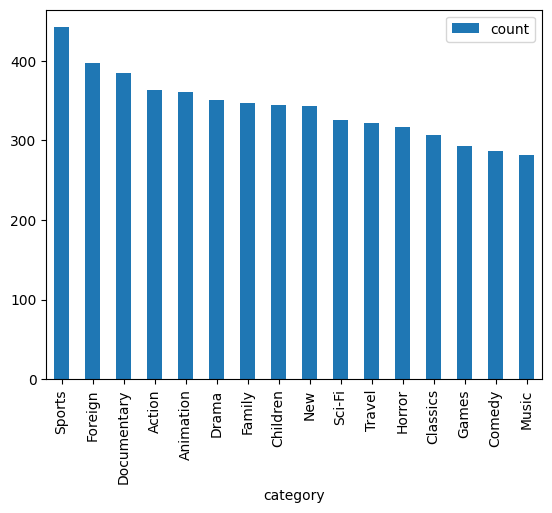

In [16]:
# plot the new df
category_freq_df.plot(kind="bar",
                      x="category",
                      y="count")